Aditya Iqbal Bagaskara and Patricia Rodriguez Vaquero

On this experiment, we followed the definition of group disagreement as well as user counting user's satisfaction as in the paper. In this method, alpha is equal to the value of group disagreement.

In [1]:
import numpy as np
import pandas as pd
import math
import statistics as stat
from scipy.stats import pearsonr, kendalltau
import matplotlib.pyplot as plt

In [2]:
def read_data_ml100k():
    names = ['userId', 'movieId', 'rating', 'timestamp']
    data = pd.read_csv('./ml-100k/u.data', '\t', names=names,
                       engine='python')
    num_users = data.userId.unique().shape[0]
    num_items = data.movieId.unique().shape[0]
    return data, num_users, num_items

ratings, num_users, num_items = read_data_ml100k()

movies = pd.read_csv (r'./ml-latest-small/movies.csv')
ratings = ratings.drop(columns = ["timestamp"])
movies = movies.drop(columns = ["genres"])

/Users/kalevkim/opt/anaconda3/envs/dataml100/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  if __name__ == '__main__':


In [3]:
def create_userX_matrix(userId):
    userX_matrix = ratings.query('userId == @userId',inplace = False)
    return userX_matrix

def user_subset_common_movie(userId):
    userX_matrix = create_userX_matrix(userId)
    users = ratings[ratings['movieId'].isin(userX_matrix['movieId'].tolist())]
    userSubsetGroup = users.groupby(['userId'])
    userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]) and len(x[1]) > 50, reverse=True)
    return userSubsetGroup, userX_matrix

def pearsonCorr(inputMovies, similarUsersGroup):
    pearsonCorrelationDict = {}
    for name, group in similarUsersGroup:
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]
        selectedUserTempRatingList = temp_df['rating'].tolist()
        similarUserTempRatingList = group['rating'].tolist()

        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)
        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)
        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

def produceRec (inputMovies, pearsonCorrelationDict):
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    topSimilarUsersRating = topSimilarUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating.head()
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating['weightedRatingScore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weightedRatingScore']]
    tempTopSimilarUsersRating.columns = ['sum_weightedRatingScore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    

    recommendation_data = pd.DataFrame()
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weightedRatingScore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    recommendation_data = recommendation_data.rename(columns=  {'weighted average recommendation score': 'scores'})
    return recommendation_data

<h1>Group Formation and Producing individual recommendations</h1>

Produce recommendation for three users. We first pick random user A and for the group formation, we use user that has high similarity with userA. High similarity is indidcated by Pearson correlation coefficient that are more than 0.7. We picked user 685 and 245

In [4]:
userA = 15
userSubsetGroupA, userAMatrix = user_subset_common_movie(userA)
pearsonCorrelationDictA = pearsonCorr(userAMatrix, userSubsetGroupA)
recMovieA = produceRec(userAMatrix, pearsonCorrelationDictA)


In [5]:
# pearsonCorrelationDictA

In [6]:
userB = 685
userSubsetGroupB, userBMatrix = user_subset_common_movie(userB)
pearsonCorrelationDictB = pearsonCorr(userBMatrix, userSubsetGroupB)
recMovieB = produceRec(userBMatrix, pearsonCorrelationDictB)


userC = 245
userSubsetGroupC, userCMatrix = user_subset_common_movie(userC)
pearsonCorrelationDictC = pearsonCorr(userCMatrix, userSubsetGroupC)
recMovieC = produceRec(userCMatrix, pearsonCorrelationDictC)

<h4>First iteration</h4>

<br>
For the first iteration, we will do the same approach as previous assignment on group recommendation using average and least misery aggregation method.
The group recommendation from this stage will be used as a starting point for the next iterations. On the first iteration, we consider that the group disagreepment (alpha) is 0 so we will use the average aggregation method only.

In [7]:
aL = recMovieA['movieId'].tolist()
bL = recMovieB['movieId'].tolist()
cL = recMovieC['movieId'].tolist()

commonRecMov = set(aL) & set(bL) & set(cL)

recA = recMovieA[recMovieA['movieId'].isin(commonRecMov)]
recB = recMovieB[recMovieB['movieId'].isin(commonRecMov)]
recC = recMovieC[recMovieC['movieId'].isin(commonRecMov)]

#aggregating the three user's recommendation with averaging method
frames = [recA, recB, recC]
result = pd.concat(frames)
GrAv = result.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
GrAv.index = [x for x in range(1, len(GrAv)+1)]
GrAv['title'] = GrAv['movieId'].map(movies['title'])
# GrAv = GrAv.rename(columns=  {'ratings': 'average_rating'})
top20Av1 = GrAv.head(20)
list20Av1Mov = top20Av1['movieId'].tolist()
top20Av1

#showing the top 20 reccommended movie for average method
#20 recommended movies for the first iteration
                           
                           

,movieId,scores,title
1,269,5.412835,Rent-a-Kid (1995)
2,302,5.190579,Ace Ventura: Pet Detective (1994)
3,325,4.182236,"Mask, The (1994)"
4,324,4.096287,Wes Craven's New Nightmare (Nightmare on Elm S...
5,50,3.576035,Georgia (1995)
6,289,3.543758,Tom & Viv (1994)
7,183,3.453709,Before Sunrise (1995)
8,98,3.443679,Taxi Driver (1976)
9,100,3.349766,Before and After (1996)
10,150,3.343509,Love & Human Remains (1993)


In [8]:
def alpha_score(userARec, userBRec, userCRec, GroupRec):
    
    list20Mov = GroupRec['movieId'].tolist()
    satUserA = np.sum(GroupRec['scores'])/np.sum(userARec[userARec['movieId'].isin(list20Mov)]['scores'])
    satUserB = np.sum(GroupRec['scores'])/np.sum(userBRec[userBRec['movieId'].isin(list20Mov)]['scores'])
    satUserC = np.sum(GroupRec['scores'])/np.sum(userCRec[userCRec['movieId'].isin(list20Mov)]['scores'])
    satUsersList = [satUserA, satUserB, satUserC]
    alpha = np.max(satUsersList) - np.min(satUsersList)
    group_sat = np.mean(satUsersList)
    
    print(f'User A sat.Score: {satUserA}')
    print(f'User B sat.Score: {satUserB}')
    print(f'User C sat.Score: {satUserC}')
    print(f'Group satisfaction score: {group_sat}')
    
    print(f'Group disagreement: {alpha}')

    return satUserA, satUserB, satUserC, alpha, group_sat
    

In [9]:
def sequential_hybrid(recAdf, recBdf, recCdf, alpha, prevIter):
    
    #erase movies that have been recommended on the previous iteration
    prevIterMov = prevIter['movieId'].tolist()    
    recAdf = recAdf[~recAdf['movieId'].isin(prevIterMov)]
    recBdf = recBdf[~recBdf['movieId'].isin(prevIterMov)]
    recCdf = recCdf[~recCdf['movieId'].isin(prevIterMov)]
    frames = [recAdf, recBdf, recCdf]

    results = pd.concat(frames)
    GrIterJAv = results.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
    GrIterJAv['scores'] = GrIterJAv['scores']*(1-alpha)
    GrIterJLM = result.groupby(['movieId'], as_index= False).min().sort_values(by='scores', ascending=False)
    GrIterJLM['scores'] = GrIterJLM['scores']*(alpha)
    
    frames = [GrIterJAv, GrIterJLM]
    comb = pd.concat(frames)
    GrIterJ = comb.groupby(['movieId'], as_index= False).sum().sort_values(by='scores', ascending=False)
    GrIterJ['title'] = GrIterJ['movieId'].map(movies['title'])
    
    
    return recAdf, recBdf, recCdf, GrIterJ

In [10]:
#get satisfaction score of thre previous iteration
satA1, satB1, satC1, alpha1, group_sat1 = alpha_score(recA, recB, recC, top20Av1)

#make new recommendation based on the previous satisfaction score
#and new users personal recommendation which deletes all movies that have been
#previously recommended


User A sat.Score: 1.203965065880961
User B sat.Score: 0.8281663547658152
User C sat.Score: 1.0395829030529553
Group satisfaction score: 1.0239047745665772
Group disagreement: 0.37579871111514584


<h4> Second Iteration </h4>

In [11]:
recA2, recB2, recC2, GRiter2 = sequential_hybrid(recA, recB, recC, alpha1, top20Av1)
GRiter2Top20 = GRiter2.head(20)
GRiter2Top20
#20 recommended movies for the second iteration

,movieId,scores,title
284,285,3.148340,Tank Girl (1995)
198,199,3.130297,Exotica (1994)
233,234,3.122646,"Madness of King George, The (1994)"
168,169,3.121599,Three Wishes (1995)
172,173,3.106514,Unstrung Heroes (1995)
708,709,3.091909,Rebecca (1940)
275,276,3.083699,"Santa Clause, The (1994)"
181,182,3.078907,Before the Rain (Pred dozhdot) (1994)
442,443,3.076865,Philadelphia (1993)
514,515,3.075605,"Wild Bunch, The (1969)"


<h4> Third Iteration 

In [12]:
satA2, satB2, satC2, alpha2, group_sat2 = alpha_score(recA2, recB2, recC2, GRiter2Top20)


recA3, recB3, recC3, GRiter3 = sequential_hybrid(recA2, recB2, recC2, alpha2, GRiter2Top20)
GRiter3Top20 = GRiter3.head(20)
GRiter3Top20

#20 recommended movies for the third iteration

User A sat.Score: 1.0366768617503233
User B sat.Score: 0.9750569960491215
User C sat.Score: 0.9139280002425024
Group satisfaction score: 0.9752206193473157
Group disagreement: 0.12274886150782083


,movieId,scores,title
173,174,3.146177,Unzipped (1995)
469,470,3.064954,Sirens (1994)
171,172,3.060260,Under Siege 2: Dark Territory (1995)
175,176,3.058478,Waterworld (1995)
90,91,3.047006,Unforgettable (1996)
723,724,3.036361,Lost Horizon (1937)
635,636,3.035772,Fled (1996)
1058,1059,3.035438,Star Trek IV: The Voyage Home (1986)
483,484,3.032012,"Three Musketeers, The (1993)"
133,134,3.029588,Crimson Tide (1995)


<h4>Fourth iteration </h4>

In [13]:
satA3, satB3, satC3, alpha3, group_sat3 = alpha_score(recA3, recB3, recC3, GRiter3Top20)

recA4, recB4, recC4, GRiter4 = sequential_hybrid(recA3, recB3, recC3, alpha3, GRiter3Top20)
GRiter4Top20 = GRiter4.head(20)
GRiter4Top20

#20 recommended movies for the fourth iteration

User A sat.Score: 1.025618743393504
User B sat.Score: 1.052093183895027
User C sat.Score: 0.9057794645897956
Group satisfaction score: 0.994497130626109
Group disagreement: 0.1463137193052313


,movieId,scores,title
282,283,2.984074,National Lampoon's Senior Trip (1995)
595,596,2.982176,Ghost in the Shell (Kôkaku kidôtai) (1995)
771,772,2.980099,Pollyanna (1960)
448,449,2.974593,"Ref, The (1994)"
1088,1089,2.974319,Mother (1996)
261,262,2.970496,"Queen Margot (Reine Margot, La) (1994)"
481,482,2.967528,Threesome (1994)
127,128,2.963238,Beyond Rangoon (1995)
961,962,2.962038,"Deer Hunter, The (1978)"
653,654,2.961895,Tales from the Crypt Presents: Bordello of Blo...


<h4>Fifth iteration </h4>

In [14]:
satA4, satB4, satC4, alpha4, group_sat4 = alpha_score(recA4, recB4, recC4, GRiter4Top20)

recA5, recB5, recC5, GRiter5 = sequential_hybrid(recA4, recB4, recC4, alpha4, GRiter4Top20)
GRiter5Top20 = GRiter5.head(20)
GRiter5Top20

#20 recommended movies for the fifth iteration

User A sat.Score: 1.0156847192230145
User B sat.Score: 1.0712774631030344
User C sat.Score: 0.8928227711035582
Group satisfaction score: 0.9932616511432024
Group disagreement: 0.17845469199947617


,movieId,scores,title
1109,1110,2.930005,McHale's Navy (1997)
525,526,2.927579,Bread and Chocolate (Pane e cioccolata) (1973)
39,40,2.926406,Mortal Kombat (1995)
207,208,2.925178,Farinelli: il castrato (1994)
649,650,2.924068,Emma (1996)
263,264,2.920485,Roommates (1995)
7,8,2.920331,Sudden Death (1995)
714,715,2.919940,Father of the Bride (1950)
55,56,2.914725,Don't Be a Menace to South Central While Drink...
825,826,2.913926,Dial M for Murder (1954)


In [15]:
satA5, satB5, satC5, alpha5, group_sat5 = alpha_score(recA5, recB5, recC5, GRiter5Top20)

User A sat.Score: 1.0029825895722473
User B sat.Score: 1.0830663844320907
User C sat.Score: 0.8835724801676421
Group satisfaction score: 0.9898738180573267
Group disagreement: 0.19949390426444857


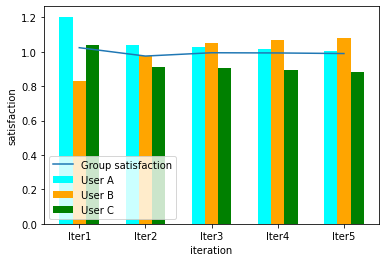

<Figure size 2400x1600 with 0 Axes>

In [16]:
labels = ['Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5']
x = np.arange(len(labels))
y1 = [satA1, satA2, satA3, satA4, satA5]
y2 = [satB1, satB2, satB3, satB4, satB5]
y3 = [satC1, satC2, satC3, satC4, satC5]
y4 = [group_sat1, group_sat2, group_sat3, group_sat4, group_sat5]
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.plot(labels, y4)
plt.xticks(x, labels)
plt.xlabel("iteration")
plt.ylabel("satisfaction")
plt.legend(["Group satisfaction","User A", "User B", "User C" ])
plt.figure(figsize=(30, 20), dpi=80)
plt.show()

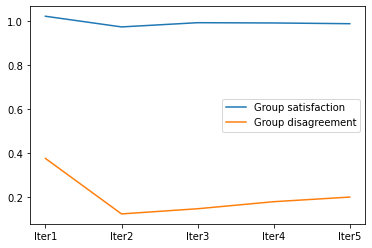

In [17]:
alphas = [alpha1, alpha2, alpha3, alpha4, alpha5]
plt.plot(labels, y4)
plt.plot(labels, alphas)

plt.legend(["Group satisfaction", "Group disagreement" ])
plt.show()

In [18]:
#overall satisfaction
userATotSat = np.sum(y1)
userBTotSat = np.sum(y2)
userCTotSat = np.sum(y3)

overalSat = (userATotSat + userBTotSat + userCTotSat)/5
print("Overall user satisfaction from 5 iteration ", overalSat)

Overall user satisfaction from 5 iteration  2.9860547962443187


In [21]:
av_dis = np.mean(alphas)
print("Average group disagreement is: ", av_dis)

Average group disagreement is:  0.2045619776384245
